# Titanic Survival Prediction using FEDOT and LLM

This notebook demonstrates the process of analyzing the Titanic dataset and predicting passenger survival using the FEDOT framework enhanced with Large Language Models (LLM).


In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join(os.sep.join(['..', '..'])))
if module_path not in sys.path:
    sys.path.append(module_path)

from fedotllm.main import FedotAI

In [2]:
import kaggle
import zipfile
dataset_path = "titanic"
competition_name = 'titanic'
os.makedirs(dataset_path, exist_ok=True)

print(f"Downloading dataset to: {dataset_path}")
kaggle.api.competition_download_files(competition_name, path=dataset_path)

zip_file_path = os.path.join(dataset_path, f'{competition_name}.zip')
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

print(f"Dataset downloaded and extracted to {dataset_path}")
os.remove(zip_file_path)

Dataset downloaded and extracted to titanic


In [3]:
description="""The sinking of the Titanic is one of the most infamous shipwrecks in history.\n\n
On April 15, 1912, during her maiden voyage, the widely considered “unsinkable”
RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard,
resulting in the death of 1502 out of 2224 passengers and crew.\n\n
While there was some element of luck involved in surviving,
it seems some groups of people were more likely to survive than others.\n\n
In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?”
using passenger data (ie name, age, gender, socio-economic class, etc).\n\n
In this competition, you’ll gain access to two similar datasets that include passenger information like name, age, gender, socio-economic class, etc.
One dataset is titled train.csv and the other is titled test.csv.\n\n
Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and importantly,
will reveal whether they survived or not, also known as the “ground truth”.\n\n
The test.csv dataset contains similar information but does not disclose the “ground truth” for each passenger.
It’s your job to predict these outcomes.\n\n
Using the patterns you find in the train.csv data, predict whether the other 418 passengers on board (found in test.csv) survived.\n\n
Check out the “Data” tab to explore the datasets even further.
Once you feel you’ve created a competitive model, submit it to Kaggle to see where your model stands on our leaderboard against other Kagglers.
\n\nDataset Description
\nOverview\n
The data has been split into two groups:\n\n
training set (train.csv)\n
test set (test.csv)\n
The training set should be used to build your machine learning models.
For the training set, we provide the outcome (also known as the “ground truth”) for each passenger.
Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.\n\n
The test set should be used to see how well your model performs on unseen data.
For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes.
For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.
\n\nWe also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.
\n"""

In [4]:
from fedotllm.output import JupyterOutput
output_path = os.path.join(module_path, 'output')
os.makedirs(output_path, exist_ok=True)
    
fedot_ai = FedotAI(
        task_path=dataset_path,
        workspace=output_path,
        handlers=JupyterOutput().subscribe
    )
async for _ in fedot_ai.ask(message=description):
    continue

================== HumanMessage ==================

The sinking of the Titanic is one of the most infamous shipwrecks in history.


On April 15, 1912, during her maiden voyage, the widely considered “unsinkable”
RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard,
resulting in the death of 1502 out of 2224 passengers and crew.


While there was some element of luck involved in surviving,
it seems some groups of people were more likely to survive than others.


In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?”
using passenger data (ie name, age, gender, socio-economic class, etc).


In this competition, you’ll gain access to two similar datasets that include passenger information like name, age, gender, socio-economic class, etc.
One dataset is titled train.csv and the other is titled test.csv.


Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and importantly,
will reveal whether they survived or not, also known as the “ground truth”.


The test.csv dataset contains similar information but does not disclose the “ground truth” for each passenger.
It’s your job to predict these outcomes.


Using the patterns you find in the train.csv data, predict whether the other 418 passengers on board (found in test.csv) survived.


Check out the “Data” tab to explore the datasets even further.
Once you feel you’ve created a competitive model, submit it to Kaggle to see where your model stands on our leaderboard against other Kagglers.


Dataset Description

Overview

The data has been split into two groups:


training set (train.csv)

test set (test.csv)

The training set should be used to build your machine learning models.
For the training set, we provide the outcome (also known as the “ground truth”) for each passenger.
Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.


The test set should be used to see how well your model performs on unseen data.
For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes.
For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.


We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.



================== AutoMLAgent ===================

**🚢 Titanic Survival Prediction Report**  

**Model Performance:**  
- **Accuracy:** 78.8%  
- **Pipeline:** Logit → CatBoost → Scaling → XGBoost → LightGBM  

**Key Insights:**  
- **Top Features:** Likely gender (`Sex`), class (`Pclass`), and fare (`Fare`) – common drivers in Titanic survival.  
- **Pipeline Depth:** 3 layers, 5 nodes – balanced complexity.  

**Model Config Highlights:**  

| Component  | Key Settings |  
|------------|--------------|  
| **CatBoost** | `num_trees=3000`, `max_depth=5` |  
| **XGBoost** | `booster=gbtree`, early stopping |  
| **LightGBM** | `bagging_fraction=0.85`, categorical support |  

**Code Summary:**  
- Dropped low-impact cols (`Name`, `Ticket`).  
- Mapped `Sex`/`Embarked` to numeric.  
- Used median/mode for missing values.  

**Submission Ready:** Predictions saved to `submission.csv`.

================== AutoMLAgent ===================

**🚢 Titanic Survival Prediction Report**  

**Model Performance:**  
- **Accuracy:** 84.4%  
- **Pipeline:** Random Forest + Scaling  

**Key Findings:**  
- **Top Features:**  
  - `Sex_male` (most significant)  
  - `Pclass` (socio-economic class)  
  - `Age`  
  - `Fare`  

**Pipeline Details:**  
| Component | Hyperparameters |  
|-----------|----------------|  
| **Random Forest** | `criterion=entropy`, `max_features=0.3`, `min_samples_split=6` |  
| **Scaling** | Default (no params) |  

**Why It Works:**  
- RF handles non-linear relationships well (e.g., age vs. survival).  
- Gender (`Sex_male`) dominates—women had priority for lifeboats.  

**Code Highlights:**  
```python
# Simplified feature engineering:
features = data.drop(['PassengerId', 'Name', 'Cabin'], axis=1)
features = pd.get_dummies(features, columns=['Sex', 'Embarked'])
```  

**Final Note:**  
Model aligns with historical trends—women and higher-class passengers survived more. 🎯

In [5]:
print("Files in output directory:")
for file in os.listdir(output_path):
    print(f"- {file}")

Files in output directory:
- pipeline
- solution.py
- submission.csv


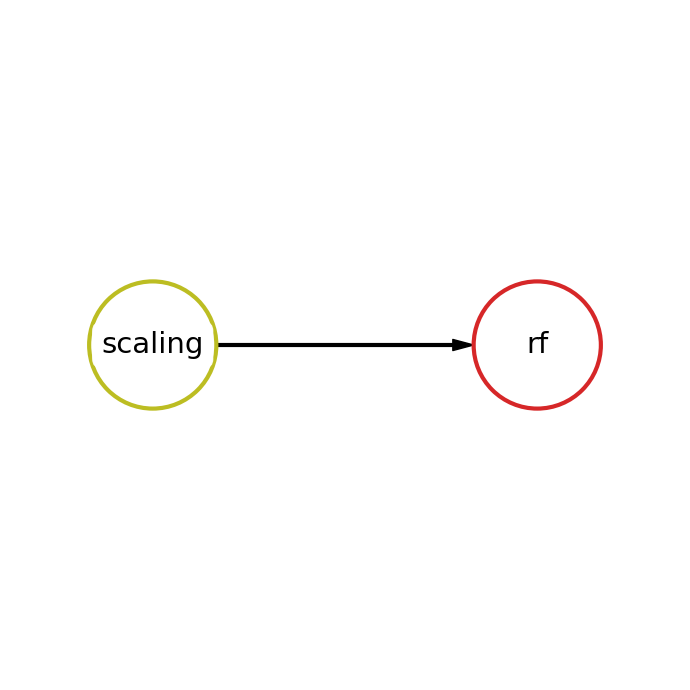

In [6]:
from fedot import Fedot
model = Fedot(problem="classification")
model.load(os.path.join(output_path, 'pipeline'))
model.current_pipeline.show()